In [1]:
# !pip install -U  byaldi pdf2image qwen-vl-utils transformers ipywidgets jinja2 einops seaborn
# Tested with byaldi==0.0.4, pdf2image==1.17.0, qwen-vl-utils==0.0.8, transformers==4.45.0

In [2]:
# !sudo apt-get install -y poppler-utils

In [3]:
# colpali modules
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)

#vison language models
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

import torch
from torch.utils.data import DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import os
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import pprint

2024-12-03 04:58:23.307250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 04:58:23.324662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 04:58:23.329998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Building a Vision-Based Retrieval System with ColPali and Qdrant 
 
- This notebook demonstrates the end-to-end process of creating a vision-based retrieval system using ColPali and Qwen2-VL. In the [companion notebook]() in the same repo, we will also outline how to commnicate with the vector store framework [Qdrant](https://qdrant.tech/) to carry out this process more efficiently. This notebooks outlines more of a low-level approach to the this problem.

- [ColPali](https://github.com/illuin-tech/colpali) is a recent breakthrough in document retrieval that leverages Vision Language Models (VLMs) to create efficient multi-vector embeddings directly from document images. The key idea is to consider each pdf page as an image and vision language model to create embeddings. This approach greatly eliminates the need for complex and brittle layout recognition and OCR pipelines. It actually outperforms other models by a big margin in several benchmarks. As a bonus, we will visualize similarity maps to see what model is looking at the token level during retrival.

 
- We will integreate [Qwen2-VL](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) into our retrieval system. This is a famous vision language model from Alibaba. Hope is that we can generate detailed and contextually relevant responses based on the images retrieved. 

- It would be hard to pull this notebook together without great resources. Check [ColPali cookboks](https://github.com/tonywu71/colpali-cookbooks), [qdrant tutorial](https://youtu.be/_A90A-grwIc?si=i9m2u_u06t9yNwbS) and [Vespa](https://blog.vespa.ai/retrieval-with-vision-language-models-colpali/) blog for more cool stuff. One last note, to make the process faster, I used ChatGPT to annote and explain the functions below better, no reason to pretend I dont use it(:

## Create Document Embeddings From PDFs

These are the models we will use, check for the ColPali websire for the other models. We can speed up the inference with "bfloat16".

In [4]:
model_name = "vidore/colpali-v1.2"
processor = ColPaliProcessor.from_pretrained(model_name)

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
).eval()

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

For ColPali, each PDF page is an image, thus we first convert all the pdf pages to images by keeping the necessary metadata int

In [5]:
pdf_dir = 'pdf_files/'

In [6]:
def convert_pdf_to_images(pdf_dir):
    """
    Converts all PDFs in a directory to images.

    Args:
        pdf_dir (str): Path to the directory containing PDFs.

    Returns:
        dict: A dictionary where keys are file names (without extension), 
              and values are lists of images (one list per PDF).
    """
    pdf_list = [pdf for pdf in os.listdir(pdf_dir) if pdf.endswith(".pdf")]
    all_images = {}

    for pdf_file in pdf_list:
        pdf_path = os.path.join(pdf_dir, pdf_file)
        pdf_images = convert_from_path(pdf_path)
        all_images[pdf_file] = pdf_images  # Use file name as key
    
    return all_images


all_images = convert_pdf_to_images(pdf_dir)

In [7]:
print(all_images.keys())

dict_keys(['rav_4.pdf'])


Our sample PDF is a Toyota RAV4 pocket user manual but you can put as many as different PDFs you wish in the folder below.
As we can see from the sample, this PDF is exteremely hard for any kind of OCR based retrived model.

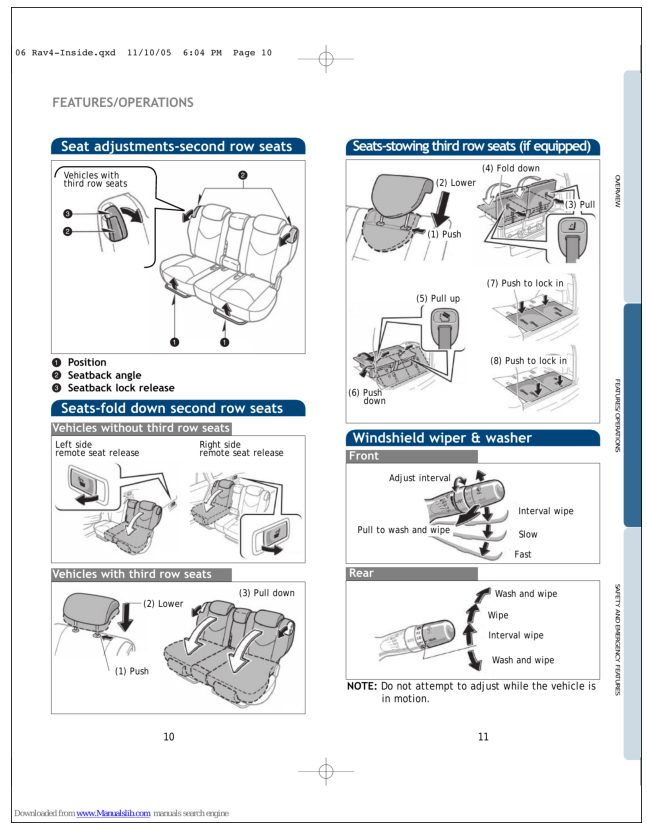

In [8]:
#lets see one sample
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(all_images['rav_4.pdf'][7])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [9]:
def create_document_embeddings(pdf_dir, model, processor, batch_size=2):
    """
    Converts all PDFs in a directory into embeddings with metadata.

    Args:
        pdf_dir (str): Directory containing PDF files.
        model: Pre-trained model for generating embeddings.
        processor: Preprocessor for the model (e.g., to process images).
        batch_size (int): Batch size for inference.

    Returns:
        list: A list of dictionaries, where each dictionary contains:
            - "embedding": The embedding tensor.
            - "doc_id": The document ID (int).
            - "page_id": The page index within the document.
            - "file_name": The name of the source PDF file.
    """
    all_images = convert_pdf_to_images(pdf_dir)
    all_embeddings_with_metadata = []

    for doc_id, (file_name, pdf_images) in enumerate(all_images.items()):
        dataloader = DataLoader(
            dataset=pdf_images,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=lambda x: processor.process_images(x),
        )

        page_counter = 0
        for batch in tqdm(dataloader, desc=f"Processing {file_name}"):
            with torch.no_grad():
                batch = {k: v.to(model.device) for k, v in batch.items()}
                batch_embeddings = model(**batch)
                batch_embeddings = list(torch.unbind(batch_embeddings.to("cpu")))

                for embedding in batch_embeddings:
                    all_embeddings_with_metadata.append({
                        "embedding": embedding,
                        "doc_id": doc_id,
                        "page_id": page_counter,
                        "file_name": file_name,  # Correctly use the file name
                    })
                    page_counter += 1

    return all_embeddings_with_metadata


In [10]:
ds = create_document_embeddings(pdf_dir, model, processor, batch_size=2)
print(f"Generated embeddings for {len(ds)} pages.")

Processing rav_4.pdf: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

Generated embeddings for 13 pages.


In [11]:
# here is the first page
ds[0]

{'embedding': tensor([[ 0.1338,  0.2773,  0.1089,  ..., -0.0245, -0.0698,  0.0786],
         [-0.0530,  0.0265,  0.0688,  ...,  0.1191, -0.0723,  0.0464],
         [-0.1904,  0.0552, -0.0189,  ...,  0.0688, -0.1504,  0.1543],
         ...,
         [ 0.0669, -0.0194,  0.0693,  ..., -0.0175, -0.1006,  0.0845],
         [ 0.0003,  0.0693,  0.0684,  ...,  0.0625, -0.0369,  0.0488],
         [-0.0337,  0.1406,  0.2402,  ...,  0.0693, -0.0742,  0.0109]],
        dtype=torch.bfloat16),
 'doc_id': 0,
 'page_id': 0,
 'file_name': 'rav_4.pdf'}

## Retrival Based on User Query

Now we are ready to retrive pages based on user query. Note that ColPali successfully identified the right pages

In [12]:
def get_results(query, processor, model, ds, all_images, top_k=5):
    """
    Retrieves top-k relevant images for a given query.

    Args:
        query (str): User query as a string.
        processor: Processor for pre-processing the query.
        model: Model to generate embeddings for the query.
        ds (list): List of dictionaries with "embedding", "doc_id", "page_id", and "file_name".
        all_images (dict): Dictionary of images per document.
        top_k (int): Number of top results to retrieve.

    Returns:
        list: A list of dictionaries, where each dictionary contains:
            - "doc_id": Document ID.
            - "page_id": Page ID.
            - "file_name": Name of the source PDF file.
            - "image": The retrieved image (PIL.Image.Image).
            - "score": Similarity score for the image.
    """
    # Process the query and move to model's device
    batch_queries = processor.process_queries([query]).to(model.device)

    # Forward pass to get query embeddings
    with torch.no_grad():
        query_embeddings = model(**batch_queries)

    # Extract embeddings from ds for scoring
    document_embeddings = torch.stack([entry["embedding"] for entry in ds])
    
    # Compute similarity scores
    scores = processor.score_multi_vector(query_embeddings, document_embeddings)
    score_values = scores[0].tolist()  # Extract similarity scores as a list

    # Get top-k indices of the most relevant embeddings
    top_indices = scores[0].topk(top_k).indices.tolist()

    # Retrieve corresponding images and metadata
    retrieved_results = []
    for idx in top_indices:
        entry = ds[idx]
        doc_id = entry["doc_id"]
        page_id = entry["page_id"]
        file_name = entry["file_name"]
        image = all_images[file_name][page_id]  # Correct lookup using file_name

        # Add score to each result
        retrieved_results.append({
            "doc_id": doc_id,
            "page_id": page_id,
            "file_name": file_name,
            "image": image,
            "score": score_values[idx],  # Add similarity score
        })

    return retrieved_results


In [13]:
query = "What is the purpose of 'AUTO LSD' switch?"
retrieved_results = get_results(
    query = query,
    processor=processor,
    model=model,
    ds=ds,
    all_images=all_images,
    top_k=2,
)

retrieved_results

[{'doc_id': 0,
  'page_id': 11,
  'file_name': 'rav_4.pdf',
  'image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  'score': 18.75},
 {'doc_id': 0,
  'page_id': 4,
  'file_name': 'rav_4.pdf',
  'image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
  'score': 17.625}]

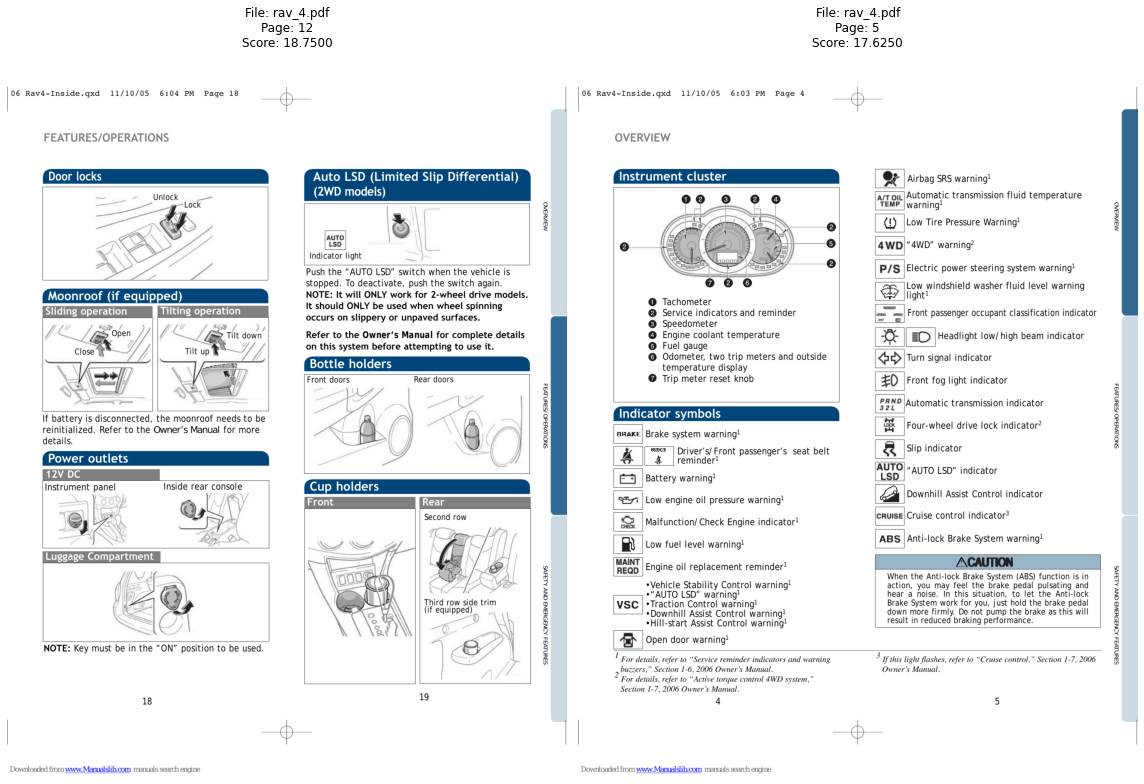

In [14]:
def display_top_two_results(retrieved_results):
    """
    Displays the top two retrieved images in a 1x2 canvas using Matplotlib.

    Args:
        retrieved_results (list): A list of dictionaries with metadata and images.

    Returns:
        None
    """
    # Take only the top two results
    top_two_results = retrieved_results[:2]

    # Create a 1x2 canvas
    fig, axes = plt.subplots(1, 2, figsize=(16, 16))

    for i, result in enumerate(top_two_results):
        file_name = result["file_name"]
        page_id = result["page_id"]
        score = result["score"]
        image = result["image"]

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"File: {file_name}\nPage: {page_id+1}\nScore: {score:.4f}")

    plt.tight_layout()
    plt.show()
display_top_two_results(retrieved_results)

## Interpretable Retrival

- Just by the contruction of ColPali, it allows us to interprate where each token in the query attends to via similarity matrix. At the end of this section, we will see that ColPali indetify relevant pieces in the images in an interpretable manner. This allows us to further the model in case of poor retrival.
- Notice how the word "LSD" is perfectly identified in the retrived image along with its surrounding tokens. Note that the process can benefit from a more detailed query

In [15]:
# this is the top ranking retrived image
image = retrieved_results[0]['image']

In [16]:
def get_query_tokens(query, processor):
    # process query
    batch_queries = processor.process_queries([query]).to(device)
    
    # get the exact token IDs after model-spesific tokenization
    query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
    query_content = query_content.replace(processor.query_augmentation_token, "").strip()
    query_tokens = processor.tokenizer.tokenize(query_content)

    return query_tokens

# now based on token ID, we can inspect the simuilari scores
query_tokens = get_query_tokens(query,processor)
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})


{0: '<bos>',
 1: 'Query',
 2: ':',
 3: '▁What',
 4: '▁is',
 5: '▁the',
 6: '▁purpose',
 7: '▁of',
 8: "▁'",
 9: 'AUTO',
 10: '▁LSD',
 11: "'",
 12: '▁switch',
 13: '?'}


In [17]:
def get_similarity_map(query, image, model, processor):
    batch_images = processor.process_images([image]).to(device)   # [B, C, 448, 448]
    batch_queries = processor.process_queries([query]).to(device) # [B, query_lenght]
    
    # Forward passes
    with torch.no_grad():
        image_embeddings = model.forward(**batch_images)          # [B, 1030, 128]
        query_embeddings = model.forward(**batch_queries)         # [B, query_lenght, 128]
    
    # Get the number of image patches
    n_patches = processor.get_n_patches(image_size=image.size, patch_size=model.patch_size) # [32, 32]

    
    # Get the tensor mask to filter out the embeddings that are not related to the image
    image_mask = processor.get_image_mask(batch_images)

    # Generate the similarity maps
    batched_similarity_maps = get_similarity_maps_from_embeddings(
        image_embeddings=image_embeddings,
        query_embeddings=query_embeddings,
        n_patches=n_patches,
        image_mask=image_mask,
    )

    # Get the similarity map for the input image. Note that each token is compared to all image patches
    similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

    return similarity_maps
    
similarity_maps =  get_similarity_map(query, image, model, processor)

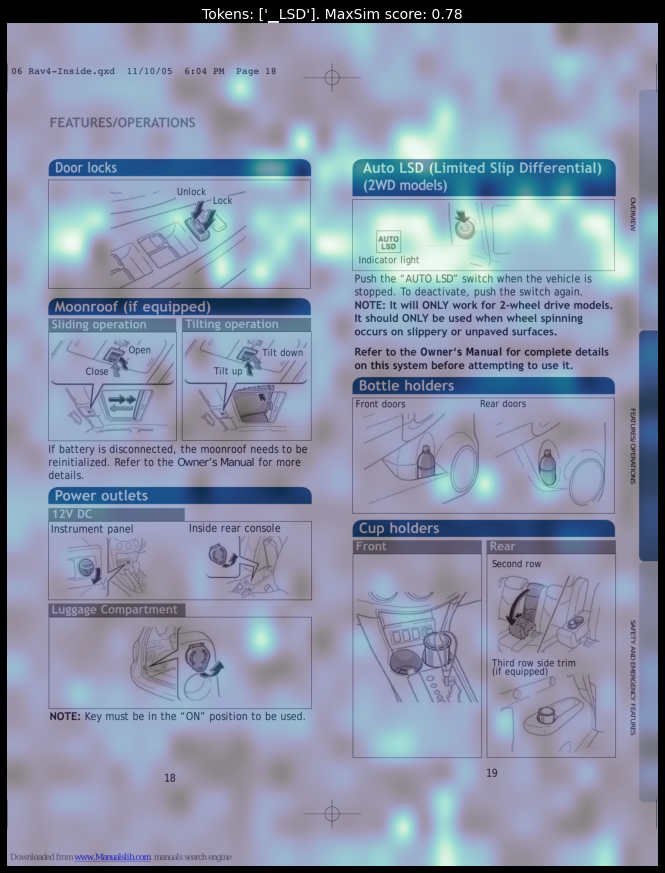

In [18]:
def display_combined_similarity_map(similarity_maps, image, token_indices):
    """
    Display the combined similarity map for multiple tokens.

    Args:
        similarity_maps: The similarity maps tensor (query_length, n_patches_x, n_patches_y).
        image: The original image.
        token_indices: A list of token indices to combine for the similarity map.
    """
    selected_tokens = [query_tokens[idx] for idx in token_indices]
    #print(f"Selected tokens: {selected_tokens}")
    
    # Combine the similarity maps for the selected tokens by averaging the maps across selected tokens
    combined_similarity_map = similarity_maps[token_indices].mean(dim=0)  
    
    # Plot the combined similarity map
    fig, ax = plot_similarity_map(
        image=image,
        similarity_map=combined_similarity_map,
        figsize=(12, 12),
        show_colorbar=False,
    )
    
    # note that this is the max of average similarity scores
    max_sim_score = combined_similarity_map.max().item()
    ax.set_title(f"Tokens: {selected_tokens}. MaxSim score: {max_sim_score:.2f}", fontsize=14)
    
    plt.show()

# Map for token "LSD"
display_combined_similarity_map(similarity_maps, image, token_indices=[10])


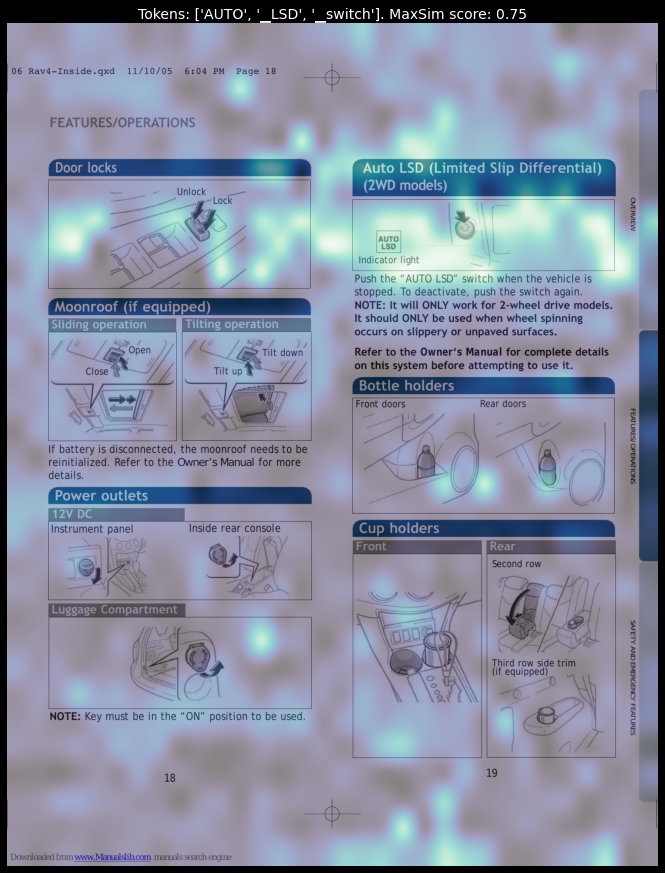

In [19]:
# AUTO + LSD + switch
display_combined_similarity_map(similarity_maps, image, token_indices=[9,10,12])

# Final Phase: Generation

Now that we managed to retrive relevant images from the pdf files, we can feed those retrived information to vision language model. We can see the pipeline we discuss so far perfectly provided an answer for our query based on retrived image by ColPali.

In [20]:
# 7B model does not fit into my GPU
vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16).to(device).eval()

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
# optimize this to fit more images to memory
min_pixels = 224 * 224
max_pixels = 1024 * 1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels
)

In [22]:
def generate_anwers(vl_model,vl_model_processor,query,grouped_images,max_new_tokens=500):
    chat_template = [
        {
            "role": "user",
            "content": [{"type": "image", "image": image} for image in grouped_images]
            + [{"type": "text", "text": query}],
        }
    ]
    # process the template
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, 
                                              add_generation_prompt=True)

    image_inputs, _ = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    ).to(device)

    # generate model output
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]

    
    

In [23]:
# note that we get the 
grouped_images = [result["image"] for result in retrieved_results]
generated_response = generate_anwers(vl_model,vl_model_processor,query,grouped_images,max_new_tokens=500)
print(generated_response)

The purpose of the 'AUTO LSD' switch is to activate the Limited Slip Differential (LSD) system in 2WD models. When the switch is pushed, the system will only work for 2-wheel drive models. It should only be used when wheel spinning occurs on slippery or unpaved surfaces.


# Full Pipeline

In [25]:
if __name__ == "__main__":
    # Define problem parameters
    pdf_dir = "pdf_files/"
    query = "What is the purpose of 'AUTO LSD' switch?"
    colpali_model_name = "vidore/colpali-v1.2"
    vl_model_name = "Qwen/Qwen2-VL-2B-Instruct"
    top_k = 1
    max_new_tokens = 500
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # define Colplai model and processor 
    colpali_processor = ColPaliProcessor.from_pretrained(colpali_model_name)
    colpali_model = ColPali.from_pretrained(
        colpali_model_name, torch_dtype=torch.bfloat16, device_map="auto"
    ).eval()

    # define vision language model and processor; optimize the input context window
   
    vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
        vl_model_name, torch_dtype=torch.bfloat16
    ).to(device).eval()
    min_pixels = 224 * 224 
    max_pixels = 1024 * 1024
    vl_model_processor = Qwen2VLProcessor.from_pretrained(vl_model_name,
                                                          min_pixels=min_pixels, max_pixels=max_pixels)

    # convert source PDFs to images
    all_images = convert_pdf_to_images(pdf_dir)

    # create document embeddings
    ds = create_document_embeddings(pdf_dir, colpali_model, colpali_processor, batch_size=2)

    # Retrieve results and group them(highest score-->lowest score)
    retrieved_results = get_results(query, colpali_processor, colpali_model, ds, all_images, top_k=top_k)
    grouped_images = [result["image"] for result in retrieved_results]

    # custom chat template
    chat_template = [
        {
            "role": "user",
            "content": [{"type": "image", "image": image} for image in grouped_images]
            + [{"type": "text", "text": query}],
        }
    ]

    # Convert to input format for the VL model
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(chat_template)

    inputs = vl_model_processor(
        text=[text], images=image_inputs, padding=True, return_tensors="pt"
    ).to(device)

    # Generate response
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    response = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]

    # Print or save the generated response
    print("Generated Response:")
    print(response)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing rav_4.pdf: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]


Generated Response:
The purpose of the 'AUTO LSD' switch is to activate the Limited Slip Differential (LSD) system in 2WD models. It is used to prevent wheel spin when driving on slippery or unpaved surfaces.
